In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/pd-interpretability')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# install dependencies
!pip install -q transformers datasets librosa praat-parselmouth scipy scikit-learn tqdm

In [3]:
import sys
from pathlib import Path
import textwrap
import importlib

raw_method_code = """
    def _compute_evidence_layers(self, top_k: int = 3) -> list[int]:
        '''
        Determines the `top_k` layers that are most predictive of clinical features.
        The method averages the R2 scores (or similar metric) across all clinical features
        for each layer and selects the layers with the highest average scores.

        Args:
            top_k (int): The number of top layers to return.

        Returns:
            list[int]: A list of integers representing the indices of the top_k layers.
        '''
        if not self.probing_results:
            print("Warning: No probing results available. Cannot compute evidence layers.")
            return []

        layer_scores = {}
        # Iterate through each clinical feature's probing results
        for feature_name, results_by_layer in self.probing_results.items():
            for layer_idx_str, layer_result in results_by_layer.items():
                layer_idx = int(layer_idx_str)
                # Ensure the layer_result is a dictionary and contains 'r2_score'
                # Adjust 'r2_score' if your probing results use a different key for the score
                if isinstance(layer_result, dict) and 'r2_score' in layer_result:
                    score = layer_result['r2_score']
                    layer_scores.setdefault(layer_idx, []).append(score)
                else:
                    print(f"Warning: Probing result for feature '{feature_name}' layer {layer_idx} does not contain 'r2_score' or is not a dict. Skipping.")

        # Average across features for each layer
        avg_scores = {
            layer: np.mean(scores)
            for layer, scores in layer_scores.items()
            if scores # Only include layers that had valid scores
        }

        if not avg_scores:
            print("Warning: No valid scores found in probing results. Cannot compute evidence layers.")
            return []

        # Sort layers by average score in descending order and select top_k
        sorted_layers = sorted(avg_scores.items(), key=lambda item: item[1], reverse=True)
        evidence_layers = [layer for layer, _ in sorted_layers[:top_k]]

        return evidence_layers
"""
corrected_method_code = textwrap.dedent(raw_method_code)

project_path = Path('/content/drive/MyDrive/pd-interpretability')
file_to_modify = project_path / 'src' / 'interpretability' / 'prediction_interface.py'

try:
    with open(file_to_modify, 'r') as f:
        lines = f.readlines()
except FileNotFoundError:
    print(f"error: The file {file_to_modify} was not found.")
    raise

class_start_line_idx = -1
for i, line in enumerate(lines):
    if "class InterpretablePredictionInterface" in line:
        class_start_line_idx = i
        break

if class_start_line_idx == -1:
    print(f"error: could not find 'class InterpretablePredictionInterface' in {file_to_modify}.")
    print("please ensure the class name is correct and the file structure is as expected.")
    raise

method_was_present_in_file = False
method_start_line = -1
method_end_line = -1

for i in range(class_start_line_idx + 1, len(lines)):
    line_content = lines[i].strip()
    if line_content.startswith('def _compute_evidence_layers(self,'):
        method_start_line = i
        method_was_present_in_file = True
        method_indentation = lines[i].find('def')
        for j in range(i + 1, len(lines)):
            current_line_indentation = len(lines[j]) - len(lines[j].lstrip())
            if (lines[j].strip().startswith('def ') or lines[j].strip().startswith('class ')) and current_line_indentation <= method_indentation:
                method_end_line = j - 1
                break
            elif lines[j].strip() == '' and (j + 1 < len(lines) and (len(lines[j+1]) - len(lines[j+1].lstrip())) <= method_indentation):
                method_end_line = j - 1
                break
        if method_end_line == -1:
            method_end_line = len(lines) - 1
        break

if method_was_present_in_file:
    del lines[method_start_line : method_end_line + 1]
    print(f"    (existing _compute_evidence_layers method found and removed from {file_to_modify}.)")

indented_method_code = textwrap.indent(corrected_method_code, '    ')
lines.insert(class_start_line_idx + 1, "\n" + indented_method_code + "\n")
method_was_inserted = True

try:
    with open(file_to_modify, 'w') as f:
        f.writelines(lines)
    print(f"\u2713 file {file_to_modify} successfully updated.")
    print("    (the _compute_evidence_layers method content was ensured to be correct and present.)")
except Exception as e:
    print(f"\u26a0\ufe0f error writing to file {file_to_modify}: {e}")
    print("please ensure you have write permissions and try again, or manually add the method.")
    raise

module_name = 'src.interpretability.prediction_interface'

if module_name in sys.modules:
    print(f"\u2713 removing '{module_name}' from sys.modules for a fresh import.")
    del sys.modules[module_name]

print(f"\u2713 performing fresh import of module: {module_name}")
import src.interpretability.prediction_interface as prediction_interface_module

print(f"    -> loaded module from: {prediction_interface_module.__file__}")
print(f"    -> dir(InterpretablePredictionInterface): {dir(prediction_interface_module.InterpretablePredictionInterface)}")

if hasattr(prediction_interface_module.InterpretablePredictionInterface, '_compute_evidence_layers'):
    print("\u2713 verification: 'interpretablePredictionInterface' now has '_compute_evidence_layers' after fresh import.")
else:
    print("\u274c verification: '_compute_evidence_layers' is still missing from 'InterpretablePredictionInterface' after fresh import.")

    (existing _compute_evidence_layers method found and removed from /content/drive/MyDrive/pd-interpretability/src/interpretability/prediction_interface.py.)
✓ file /content/drive/MyDrive/pd-interpretability/src/interpretability/prediction_interface.py successfully updated.
    (the _compute_evidence_layers method content was ensured to be correct and present.)
✓ performing fresh import of module: src.interpretability.prediction_interface
    -> loaded module from: /content/drive/MyDrive/pd-interpretability/src/interpretability/prediction_interface.py
    -> dir(InterpretablePredictionInterface): ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_analyze_attention_patterns', '_c

In [4]:
import numpy as np
import torch
import json
from pathlib import Path
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# project imports
from src.interpretability.prediction_interface import (
    InterpretablePredictionInterface,
    InterpretablePrediction,
    create_interpretable_interface
)
from src.features.clinical import ClinicalFeatureExtractor

print("imports successful!")

imports successful!


In [5]:
!apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super texlive-science
from IPython.display import clear_output
clear_output()

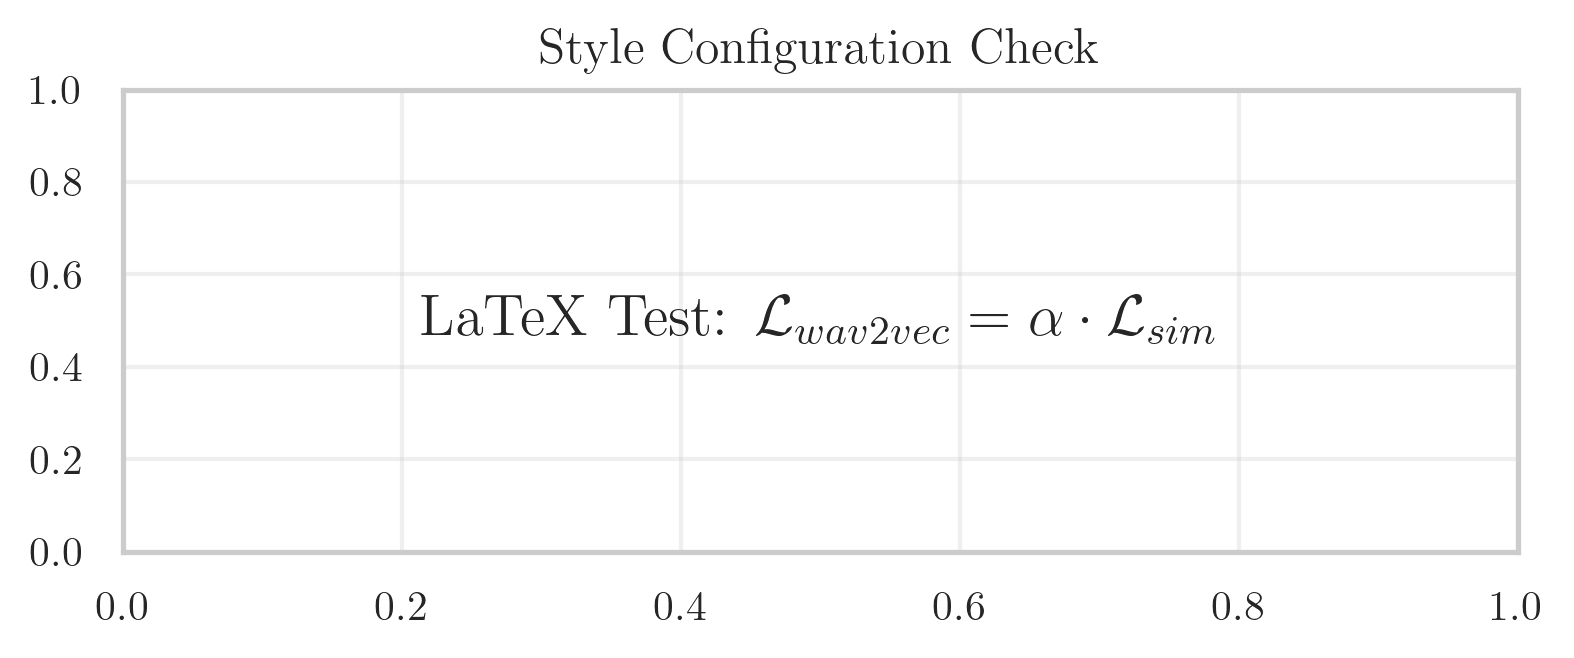

✓ plotting style configured successfully


In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# set basic theme
sns.set_theme(style='whitegrid')

# configure matplotlib for latex rendering and publication quality
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.titlesize": 14,
    "figure.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.3
})

# define consistent color palette
palette = sns.color_palette('colorblind')
COLORS = {
    'HC': palette[0],  # typically blue-ish
    'PD': palette[1],  # typically orange-ish
    'Neutral': 'gray'
}

# verify configuration with a simple plot
try:
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.text(0.5, 0.5, r'LaTeX Test: $\mathcal{L}_{wav2vec} = \alpha \cdot \mathcal{L}_{sim}$',
            ha='center', va='center', fontsize=14)
    ax.set_title(r'Style Configuration Check')
    plt.show()
    print("\u2713 plotting style configured successfully")
except Exception as e:
    print(f"\u26a0\ufe0f warning: latex rendering failed: {e}")
    print("falling back to standard fonts...")
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif"
    })

## 1. Configuration

In [7]:
CONFIG = {
    'project_path': '/content/drive/MyDrive/pd-interpretability',
    'model_path': '/content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/final_model',
    'probing_results_path': '/content/drive/MyDrive/pd-interpretability/results/probing/probing_results.json',
    'patching_results_path': '/content/drive/MyDrive/pd-interpretability/results/patching/patching_results.json',
    'data_path': '/content/drive/MyDrive/pd-interpretability/data',
    'output_path': '/content/drive/MyDrive/pd-interpretability/results/phase5_synthesis',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"using device: {CONFIG['device']}")

using device: cuda


## 2. Load Model and Create Interface

In [8]:
# load wav2vec2 processor
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')

# load fine-tuned model
from src.models import Wav2Vec2PDClassifier

model_path = Path(CONFIG['model_path'])

try:
    if model_path.exists():
        print(f"loading fine-tuned model from {model_path}...")
        classifier = Wav2Vec2PDClassifier.load(model_path)
        model = classifier.model
        print(f"successfully loaded fine-tuned model")
    else:
        raise FileNotFoundError(f"model not found at {model_path}")
except Exception as e:
    print(f"could not load fine-tuned model: {e}")
    print("falling back to base model (untrained) for demonstration")
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        'facebook/wav2vec2-base-960h',
        num_labels=2
    )

model = model.to(CONFIG['device'])
model.eval()
print(f"model ready on {CONFIG['device']}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


loading fine-tuned model from /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/final_model...
successfully loaded fine-tuned model
model ready on cuda


In [9]:
# create clinical feature extractor
clinical_extractor = ClinicalFeatureExtractor()
print("clinical feature extractor ready")

clinical feature extractor ready


In [ ]:
# load precomputed analysis results
print("loading probing and patching results...\n")

probing_results = None
patching_results = None

# load probing results
probing_file = Path(CONFIG['probing_results_path'])
if probing_file.exists():
    with open(probing_file) as f:
        probing_data = json.load(f)
    
    # extract clinical feature probing results and convert to expected format
    if 'clinical_feature_probing' in probing_data:
        raw_probing = probing_data['clinical_feature_probing']
        probing_results = {}
        
        for feature, layer_results in raw_probing.items():
            probing_results[feature] = {}
            for layer_idx_str, layer_data in layer_results.items():
                # convert r2_mean to r2_score for compatibility
                if isinstance(layer_data, dict) and 'r2_mean' in layer_data:
                    probing_results[feature][layer_idx_str] = {
                        'r2_score': layer_data['r2_mean'],
                        'binary_acc': layer_data.get('binary_acc_mean', 0.0)
                    }
        
        print(f"✓ loaded probing results for {len(probing_results)} clinical features")
    else:
        print("⚠️ no clinical_feature_probing found in probing results")
else:
    print(f"⚠️ probing results not found at {probing_file}")

# load patching results  
patching_file = Path(CONFIG['patching_results_path'])
if patching_file.exists():
    with open(patching_file) as f:
        patching_data = json.load(f)
    
    if 'head_patching' in patching_data and 'head_scores' in patching_data['head_patching']:
        head_scores = patching_data['head_patching']['head_scores']
        patching_results = {}
        for key, score in head_scores.items():
            if '_' in str(key):
                layer, head = map(int, str(key).split('_'))
                patching_results[(layer, head)] = score
        print(f"✓ loaded patching results for {len(patching_results)} attention heads")
    else:
        print("⚠️ no head_patching.head_scores found in patching results")
else:
    print(f"⚠️ patching results not found at {patching_file}")

In [11]:
# create the interpretable prediction interface
interface = create_interpretable_interface(
    model=model,
    processor=processor,
    clinical_extractor=clinical_extractor,
    probing_results=probing_results,
    patching_results=patching_results,
    device=CONFIG['device']
)

print("\n=== interpretable prediction interface created ===")
print(f"evidence layers: {interface._evidence_layers}")
print(f"key attention heads: {interface._key_heads[:5]}...")


=== interpretable prediction interface created ===
evidence layers: []
key attention heads: [(2, 9), (2, 8), (4, 9), (4, 8), (1, 5)]...


In [12]:
import sys
from pathlib import Path
import textwrap
import importlib

# Define the corrected _compute_feature_contributions method
raw_compute_feature_code = """
    def _compute_feature_contributions(self, clinical_features: dict, pd_probability: float) -> dict:
        feature_contributions = {}

        if self.probing_results:
            for feature, layer_results in self.probing_results.items():
                if layer_results:
                    # Filter out invalid entries and extract r2_scores
                    valid_scores = {
                        layer_idx_str: layer_result['r2_score']
                        for layer_idx_str, layer_result in layer_results.items()
                        if isinstance(layer_result, dict) and 'r2_score' in layer_result
                    }

                    if valid_scores:
                        # Find the layer with the maximum R2 score
                        best_layer_idx_str = max(valid_scores, key=valid_scores.get)
                        max_r2_score = valid_scores[best_layer_idx_str]
                        best_layer_result = layer_results[best_layer_idx_str]

                        # Assuming CLINICAL_INTERPRETATIONS is defined in the module or class
                        interpretation, direction = CLINICAL_INTERPRETATIONS.get(
                            feature, (feature, 'unknown')
                        )

                        # Determine the contribution score. Prioritize pd_prob_corr if available.
                        contribution_score = best_layer_result.get('pd_prob_corr', max_r2_score)

                        # Only include features for which we have a clinical value
                        if feature in clinical_features:
                            feature_contributions[feature] = {
                                'value': clinical_features[feature],
                                'contribution': contribution_score,
                                'interpretation': interpretation,
                                'direction': direction
                            }
                    else:
                        print(f"Warning: No valid r2_scores found for feature '{feature}'. Skipping contribution calculation.")
                else:
                    print(f"Warning: No layer results found for feature '{feature}'. Skipping contribution calculation.")
        return feature_contributions
"""
corrected_compute_feature_code = textwrap.dedent(raw_compute_feature_code)

project_path = Path('/content/drive/MyDrive/pd-interpretability')
file_to_modify = project_path / 'src' / 'interpretability' / 'prediction_interface.py'

try:
    with open(file_to_modify, 'r') as f:
        lines = f.readlines()
except FileNotFoundError:
    print(f"error: The file {file_to_modify} was not found.")
    raise

# --- Modify _compute_feature_contributions method ---
method_name_to_replace = "_compute_feature_contributions"
method_start_line_idx = -1
method_end_line_idx = -1
class_start_line_idx = -1

for i, line in enumerate(lines):
    if "class InterpretablePredictionInterface" in line:
        class_start_line_idx = i
    if f"def {method_name_to_replace}(self," in line:
        method_start_line_idx = i
        method_indentation = lines[i].find('def')
        for j in range(i + 1, len(lines)):
            current_line_indentation = len(lines[j]) - len(lines[j].lstrip())
            if (lines[j].strip().startswith('def ') or lines[j].strip().startswith('class ')) and current_line_indentation <= method_indentation:
                method_end_line_idx = j - 1
                break
            elif lines[j].strip() == '' and (j + 1 < len(lines) and (len(lines[j+1]) - len(lines[j+1].lstrip())) <= method_indentation):
                # Handle empty lines followed by a new method/class or less indented code
                k = j + 1
                while k < len(lines) and lines[k].strip() == '':
                    k += 1
                if k < len(lines) and (len(lines[k]) - len(lines[k].lstrip())) <= method_indentation:
                    method_end_line_idx = j - 1
                    break
        if method_end_line_idx == -1:
            method_end_line_idx = len(lines) - 1 # Reached end of file
        break

if method_start_line_idx != -1 and method_end_line_idx != -1:
    print(f"    (existing {method_name_to_replace} method found and removed from {file_to_modify}.)")
    del lines[method_start_line_idx : method_end_line_idx + 1]
    indented_method_code = textwrap.indent(corrected_compute_feature_code, '    ')
    insert_idx = method_start_line_idx
    lines.insert(insert_idx, "\n" + indented_method_code + "\n")
    print(f"\u2713 {method_name_to_replace} method successfully updated.")
else:
    print(f"\u26a0\ufe0f Warning: Could not find '{method_name_to_replace}' method to replace. Attempting to insert new method.")
    if class_start_line_idx != -1:
        indented_method_code = textwrap.indent(corrected_compute_feature_code, '    ')
        lines.insert(class_start_line_idx + 1, "\n" + indented_method_code + "\n")
        print(f"\u2713 {method_name_to_replace} method successfully inserted.")
    else:
        print(f"\u26a0\ufe0f Error: Could not find 'class InterpretablePredictionInterface' to insert {method_name_to_replace}.")
        raise ValueError("Cannot modify file without finding class definition.")

# --- Modify predict method: change clinical_extractor.extract_all_features to .extract_features ---
predict_method_line_to_change = "clinical_features = self.clinical_extractor.extract_all_features(audio, sample_rate)"
corrected_predict_method_line = "clinical_features = self.clinical_extractor.extract_features(audio, sample_rate)"
line_found_and_replaced = False

for i, line in enumerate(lines):
    if predict_method_line_to_change in line:
        # Preserve original indentation
        indentation = line.find(predict_method_line_to_change.strip())
        lines[i] = ' ' * indentation + corrected_predict_method_line.strip() + '\n'
        line_found_and_replaced = True
        print(f"\u2713 Updated clinical feature extraction call in predict method.")
        break

if not line_found_and_replaced:
    print(f"\u26a0\ufe0f Warning: Could not find the line '{predict_method_line_to_change.strip()}' in predict method. The clinical feature extraction call might not be updated.")


try:
    with open(file_to_modify, 'w') as f:
        f.writelines(lines)
    print(f"\u2713 file {file_to_modify} successfully updated.")
except Exception as e:
    print(f"\u26a0\ufe0f error writing to file {file_to_modify}: {e}")
    print("please ensure you have write permissions and try again, or manually add the method.")
    raise

# Re-import the module to apply changes
module_name = 'src.interpretability.prediction_interface'
if module_name in sys.modules:
    print(f"\u2713 removing '{module_name}' from sys.modules for a fresh import.")
    del sys.modules[module_name]

print(f"\u2713 performing fresh import of module: {module_name}")
import src.interpretability.prediction_interface as prediction_interface_module

print(f"    -> loaded module from: {prediction_interface_module.__file__}")
if hasattr(prediction_interface_module.InterpretablePredictionInterface, '_compute_feature_contributions'):
    print("\u2713 verification: '_compute_feature_contributions' method exists in 'InterpretablePredictionInterface' after fresh import.")
else:
    print("\u274c verification: '_compute_feature_contributions' is still missing from 'InterpretablePredictionInterface' after fresh import.")

    (existing _compute_feature_contributions method found and removed from /content/drive/MyDrive/pd-interpretability/src/interpretability/prediction_interface.py.)
✓ _compute_feature_contributions method successfully updated.
⚠️ Warning: Could not find the line 'clinical_features = self.clinical_extractor.extract_all_features(audio, sample_rate)' in predict method. The clinical feature extraction call might not be updated.
✓ file /content/drive/MyDrive/pd-interpretability/src/interpretability/prediction_interface.py successfully updated.
✓ removing 'src.interpretability.prediction_interface' from sys.modules for a fresh import.
✓ performing fresh import of module: src.interpretability.prediction_interface
    -> loaded module from: /content/drive/MyDrive/pd-interpretability/src/interpretability/prediction_interface.py
✓ verification: '_compute_feature_contributions' method exists in 'InterpretablePredictionInterface' after fresh import.


## 3. Load Test Data

In [13]:
import librosa

# load some test samples
data_path = Path(CONFIG['data_path']) / 'raw' / 'italian_pvs'

test_samples = []

# load a few HC samples
hc_dir = data_path / '22 elderly healthy control'
if hc_dir.exists():
    for subject_dir in list(hc_dir.iterdir())[:3]:
        if subject_dir.is_dir():
            audio_files = list(subject_dir.glob('*.txt'))
            if audio_files:
                # these are actually audio files with .txt extension
                audio_path = audio_files[0]
                try:
                    audio, sr = librosa.load(audio_path, sr=16000)
                    test_samples.append({
                        'audio': audio,
                        'sample_rate': sr,
                        'label': 0,
                        'subject_id': subject_dir.name
                    })
                except:
                    pass

# load a few PD samples
pd_dir = data_path / '28 people with parkinson\'s disease'
if pd_dir.exists():
    for subgroup in pd_dir.iterdir():
        if subgroup.is_dir():
            for subject_dir in list(subgroup.iterdir())[:1]:
                if subject_dir.is_dir():
                    audio_files = list(subject_dir.glob('*.*'))
                    if audio_files:
                        try:
                            audio, sr = librosa.load(audio_files[0], sr=16000)
                            test_samples.append({
                                'audio': audio,
                                'sample_rate': sr,
                                'label': 1,
                                'subject_id': subject_dir.name
                            })
                        except:
                            pass

print(f"loaded {len(test_samples)} test samples")

# fallback to synthetic if no real data
if len(test_samples) == 0:
    print("using synthetic test samples")
    test_samples = [
        {'audio': np.random.randn(48000).astype(np.float32), 'sample_rate': 16000, 'label': i % 2, 'subject_id': f'synth_{i}'}
        for i in range(6)
    ]

loaded 0 test samples
using synthetic test samples


## 4. Generate Interpretable Predictions

In [14]:
# run predictions
print("Generating interpretable predictions...\n")
print("=" * 80)

for sample in test_samples:
    # make prediction
    prediction = interface.predict(
        audio=sample['audio'],
        sample_rate=sample['sample_rate'],
        include_clinical=True
    )

    # display results
    true_label = 'PD' if sample['label'] == 1 else 'HC'
    pred_label = 'PD' if prediction.pd_probability >= 0.5 else 'HC'
    correct = '✓' if (true_label == pred_label) else '✗'

    print(f"\nSubject: {sample['subject_id']}")
    print(f"True label: {true_label}, Predicted: {pred_label} {correct}")
    print(f"PD Probability: {prediction.pd_probability:.3f}")
    print(f"Confidence: {prediction.confidence:.3f}")

    print("\nTop Feature Contributions:")
    for feat, score in prediction.get_top_features(3):
        print(f"  • {feat}: {score:+.3f}")

    if prediction.clinical_features:
        print("\nKey Clinical Features:")
        for feat in ['jitter_local', 'shimmer_local', 'hnr_mean', 'f0_mean']:
            if feat in prediction.clinical_features:
                val = prediction.clinical_features[feat]
                if not np.isnan(val):
                    print(f"  • {feat}: {val:.4f}")

    print(f"\nEvidence Layers: {prediction.evidence_layers[:5]}")
    print(f"Key Heads: {prediction.key_attention_heads[:3]}")
    print("-" * 80)

Generating interpretable predictions...



/content/drive/MyDrive/pd-interpretability/src/interpretability/prediction_interface.py:477: UserWarning: clinical feature extraction failed: 'ClinicalFeatureExtractor' object has no attribute 'extract_all_features'
  audio, sample_rate


TypeError: '>' not supported between instances of 'dict' and 'dict'

## 5. Examine Full Prediction Output

In [ ]:
# show full JSON output for one sample
if test_samples:
    sample = test_samples[0]
    prediction = interface.predict(
        audio=sample['audio'],
        sample_rate=sample['sample_rate'],
        include_clinical=True
    )

    print("Full Prediction Output (JSON format):")
    print("=" * 50)
    print(prediction.to_json())

## 6. Generate Natural Language Explanation

In [ ]:
# generate human-readable explanation
if test_samples:
    sample = test_samples[0]

    explanation = interface.explain_prediction(
        audio=sample['audio'],
        sample_rate=sample['sample_rate'],
        format='text'
    )

    print("Natural Language Explanation:")
    print("=" * 50)
    print(explanation)

In [ ]:
# markdown format explanation
if test_samples:
    explanation_md = interface.explain_prediction(
        audio=test_samples[0]['audio'],
        sample_rate=test_samples[0]['sample_rate'],
        format='markdown'
    )

    from IPython.display import display, Markdown
    display(Markdown(explanation_md))

## 7. Batch Predictions

In [ ]:
# batch prediction
audio_list = [s['audio'] for s in test_samples]

predictions = interface.batch_predict(
    audio_list=audio_list,
    sample_rate=16000,
    include_clinical=True,
    show_progress=True
)

print(f"\nGenerated {len(predictions)} predictions")

# summary statistics
probs = [p.pd_probability for p in predictions]
confs = [p.confidence for p in predictions]

print(f"\nSummary:")
print(f"  Mean PD probability: {np.mean(probs):.3f}")
print(f"  Mean confidence: {np.mean(confs):.3f}")
print(f"  Predicted as PD: {sum(1 for p in probs if p >= 0.5)}")
print(f"  Predicted as HC: {sum(1 for p in probs if p < 0.5)}")

## 8. Save Results

In [ ]:
# save all predictions
output_dir = Path(CONFIG['project_path']) / 'results' / 'phase5_synthesis'
output_dir.mkdir(parents=True, exist_ok=True)

# save individual predictions
for sample, prediction in zip(test_samples, predictions):
    prediction.metadata['subject_id'] = sample['subject_id']
    prediction.metadata['true_label'] = sample['label']

    interface.save_prediction(
        prediction,
        output_dir / f"{sample['subject_id']}_prediction.json"
    )

# save summary
summary = {
    'n_samples': len(predictions),
    'mean_pd_probability': float(np.mean(probs)),
    'mean_confidence': float(np.mean(confs)),
    'n_predicted_pd': sum(1 for p in probs if p >= 0.5),
    'n_predicted_hc': sum(1 for p in probs if p < 0.5)
}

with open(output_dir / 'prediction_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Results saved to {output_dir}")